# Libraries

In [3]:
## Initialzing and loading required libraries and subfunctions
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy


import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert
from scipy.signal import decimate
from scipy.ndimage import convolve1d

import pywt

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
# import umap.umap_ as umap
# import skdim
from scipy.spatial import cKDTree
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
import numpy as np
from neurodsp.filt import filter_signal
import copy
import emd
from scipy.spatial import cKDTree
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from scipy.stats import zscore


sns.set(style='white', context='notebook')

# Code

In [4]:
path_to_hpc = r'D:\3__Donders\Sep2025\OS_basic_separated\6\CN\Post_trial1_2018-02-22_09-59-19\HPC_100_CH2.continuous.mat'
path_to_pfc = r'D:\3__Donders\Sep2025\OS_basic_separated\6\CN\Post_trial1_2018-02-22_09-59-19\PFC_100_CH33.continuous.mat'
path_to_states = r'D:\3__Donders\Sep2025\OS_basic_separated\6\CN\Post_trial1_2018-02-22_09-59-19\post_trial1_2018-02-22_09-59-19-states.mat'

In [333]:
path_to_hpc = r'D:\3__Donders\Sep2025\OS_basic_separated\11\HC\2018-11-02_10-56-09_Post_Trial1\HPC_100_CH32_0.continuous.mat'
path_to_pfc = r'D:\3__Donders\Sep2025\OS_basic_separated\11\HC\2018-11-02_10-56-09_Post_Trial1\PFC_100_CH45_0.continuous.mat'
path_to_states = r'D:\3__Donders\Sep2025\OS_basic_separated\11\HC\2018-11-02_10-56-09_Post_Trial1\2018-11-02_10-56-09_post_trial1-states.mat'

In [2]:
path_to_hpc = r'D:\3__Donders\Sep2025\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\HPC_100_CH32_0.continuous.mat'
path_to_pfc = r'D:\3__Donders\Sep2025\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\PFC_100_CH45_0.continuous.mat'
path_to_states = r'D:\3__Donders\Sep2025\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\2018-11-05_14-15-28_post_trial5-states.mat'

In [5]:
config = emd.sift.SiftConfig.from_yaml_file(r'D:\3__Donders\Sep2025\mani-data-example\mani-data-example\emd_masksift_CA1_config_2500.yml')

In [6]:
lfpPFC, hypno1, fs = get_data(path_to_pfc, path_to_states, 'PFC')
print(fs)
lfpHPC, hypno2, fs = get_data(path_to_hpc, path_to_states, 'HPC')
print(fs)

2500
2500


In [7]:
print(len(lfpPFC))

6751488


In [8]:
np.unique(hypno2)

array([1, 3, 4, 5], dtype=uint8)

In [9]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    phasic_interval = nap.IntervalSet(start, end)

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intrevals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intrevals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [10]:
phasic_interval_hpc, tonic_interval_hpc, lfp_hpc = extract_pt_intervals(lfpHPC, hypno2)

Number of detected Tonic intrevals:4
Number of detected Tonic intrevals after threshold:4


In [11]:
print("Tonic Intervals:")
print(tonic_interval_hpc.shape)
print(tonic_interval_hpc)
print("----------------------------------------------------")
print("Phasic Intervals:")
print(phasic_interval_hpc.shape)
print(phasic_interval_hpc)

Tonic Intervals:
(4, 2)
  index    start      end
      0  2403     2427.18
      1  2428.18  2440.65
      2  2444.91  2474.3
      3  2475.73  2538
shape: (4, 2), time unit: sec.
----------------------------------------------------
Phasic Intervals:
(3, 2)
  index    start      end
      0  2427.18  2428.18
      1  2440.65  2444.91
      2  2474.3   2475.73
shape: (3, 2), time unit: sec.


In [12]:
def extract_imfs_by_pt_intervals(lfp, fs, interval, config, return_imfs_freqs=False):

    all_imfs = []
    all_imf_freqs = []
    rem_lfp = []
    all_masked_freqs = []
    for ii in range(len(interval)):
        start_idx = int(interval.loc[ii, 'start'] * fs)
        end_idx = int(interval.loc[ii, 'end'] * fs)
        sig_part = lfp[start_idx:end_idx]
        sig = np.array(sig_part)
        print(len(sig))

        rem_lfp.append(sig)

        try:
            imf, mask_freq = sift.mask_sift(sig, **config) 
            # imf, mask_freq = sift.mask_sift(sig, ret_mask_freq=True)
        except Exception as e:
            print(f"EMD Sift failed: {e}. Skipping this interval.")
            continue
        all_imfs.append(imf)
        all_masked_freqs.append(mask_freq)

        imf_frequencies = imf_freq(imf, fs)
        all_imf_freqs.append(imf_frequencies)

    if return_imfs_freqs:
        return all_imfs, all_imf_freqs, rem_lfp
    else:
        return all_imfs

In [13]:
tonic_imfs_hpc, tonic_imfs_freqs_hpc, tonic_rem_lpf_hpc = extract_imfs_by_pt_intervals(lfp_hpc, fs, tonic_interval_hpc, config, return_imfs_freqs=True)

phasic_imfs_hpc, phasic_imfs_freqs_hpc, phasic_rem_lpf_hpc = extract_imfs_by_pt_intervals(lfp_hpc, fs, phasic_interval_hpc, config, return_imfs_freqs=True)

60454
31180
73481
155680
2496
10649
3560


In [14]:
print("Tonic intervals imfs:")
for i, imf_mat in enumerate(tonic_imfs_hpc):
    print(f"Interval {i}: {imf_mat.shape}")  # (n_samples_in_interval, n_imfs) 
print("-----------------------------------") 
print("Phasic intervals imfs:")
for i, imf_mat in enumerate(phasic_imfs_hpc):
    print(f"Interval {i}: {imf_mat.shape}") 
    

Tonic intervals imfs:
Interval 0: (60454, 6)
Interval 1: (31180, 6)
Interval 2: (73481, 6)
Interval 3: (155680, 6)
-----------------------------------
Phasic intervals imfs:
Interval 0: (2496, 6)
Interval 1: (10649, 6)
Interval 2: (3560, 6)


In [15]:
freqs_intervalll = tonic_imfs_freqs_hpc[0]
print("Frequencies for tonic interval 0:")
for imf_idx, freqs in enumerate(freqs_intervalll):
    print(f"IMF {imf_idx+1}: freq = {freqs}")


Frequencies for tonic interval 0:
IMF 1: freq = 306.5446427686857
IMF 2: freq = 108.75888458032891
IMF 3: freq = 54.042221927617966
IMF 4: freq = 25.71457129636937
IMF 5: freq = 16.285683648538363
IMF 6: freq = 7.3192778992579


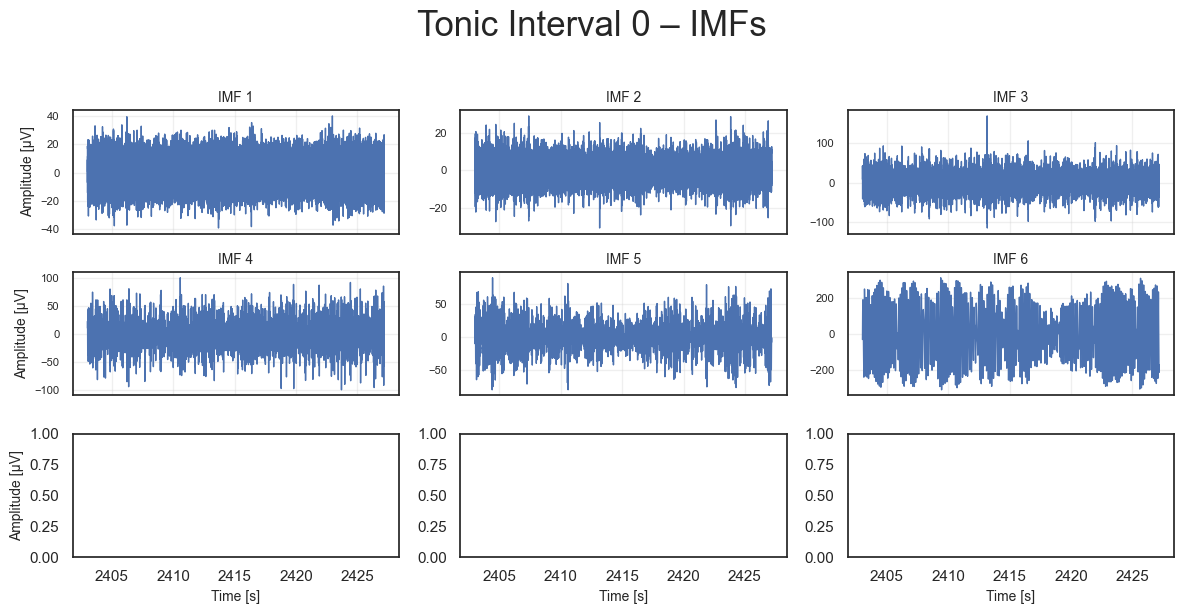

In [16]:
interval_idx = 0
imf_mat = tonic_imfs_hpc[interval_idx]   
n_samples, n_imfs = imf_mat.shape

# Time axis in seconds
start_sec = float(tonic_interval_hpc.loc[interval_idx, 'start'])
end_sec   = float(tonic_interval_hpc.loc[interval_idx, 'end'])
t = np.linspace(start_sec, end_sec, n_samples)

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(12, 6), sharex=True, sharey=False)
axes = axes.flatten()

for k in range(n_imfs):
    axes[k].plot(t, imf_mat[:, k], linewidth=1)
    axes[k].set_title(f"IMF {k+1}", fontsize=10)
    axes[k].tick_params(axis='both', which='major', labelsize=8)
    axes[k].grid(alpha=0.3)

# Add x and y labels to outer plots only
for ax in axes[6:]:  # bottom row x-labels
    ax.set_xlabel("Time [s]", fontsize=10)
for ax in axes[::3]:  # left column y-labels
    ax.set_ylabel("Amplitude [µV]", fontsize=10)

fig.suptitle(f"Tonic Interval {interval_idx} – IMFs", fontsize=25, y=1.02)
plt.tight_layout()
plt.show()


In [17]:
def get_cycle_data(imf5, fs):
    cycle_data = {"fs": None, 'theta_imf': None,
                       "IP": None, "IF": None, "IP": None, "cycles": None}


    # Get cycles using IP
    IP, IF, IA = emd.spectra.frequency_transform(imf5, fs, 'hilbert')
    C = emd.cycles.Cycles(IP)
    cycles = get_cycles_with_metrics(C, imf5, IA, IF)

    cycle_data['fs'] = fs
    cycle_data['theta_imf'] = imf5
    cycle_data['IP'] = IP
    cycle_data['IF'] = IF
    cycle_data['IA'] = IA
    cycle_data['cycles'] = cycles
    return cycle_data

In [18]:
def extract_cycle_info(imfs, imf_frequencies, fs):

  all_FPPs = []
  all_cycles_se =[]
  all_cycles_ctrl = []

  theta_range = [5, 12]
  # frequencies = np.arange(15, 141, 1)
  frequencies = np.arange(20, 180, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/12

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']

    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)

    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    ctrl = emd.cycles.get_control_points(imf[:, 5], cycle_data['cycles'], mode='augmented')
    cycle_ctrls = get_cycle_ctrl(ctrl, subset_indices)
    all_cycles_ctrl.append(cycle_ctrls)
    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    all_cycles_se.append(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

  return all_cycles_ctrl, all_cycles_se, all_FPPs

In [19]:
print(len(phasic_imfs_freqs_hpc))

3


In [20]:
# HPC Theta Cycles
all_phasic_cycles_ctrls_hpc, all_phasic_cycles_se_hpc, all_phasic_FPPs_hpc = extract_cycle_info(phasic_imfs_hpc, phasic_imfs_freqs_hpc, fs)
all_tonic_cycles_ctrls_hpc, all_tonic_cycles_se_hpc, all_tonic_FPPs_hpc = extract_cycle_info(tonic_imfs_hpc, tonic_imfs_freqs_hpc, fs)



 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'


In [21]:
print(all_phasic_FPPs_hpc[0].shape)

(7, 160, 19)


In [22]:
# (number of cycles, freq bands, phase)
print(all_tonic_FPPs_hpc[0].shape)
print(len(all_tonic_cycles_se_hpc[0]))

(145, 160, 19)
145


In [23]:
k = 0

# FPPs = all_tonic_FPPs_hpc
# CYCLE_INDS = all_tonic_cycles_se_hpc
# CYCLE_CTRL = all_tonic_cycles_ctrls_hpc
# IMFss = tonic_imfs_hpc
# REM_LFP = tonic_rem_lpf_hpc

FPPs = all_phasic_FPPs_hpc
CYCLE_INDS = all_phasic_cycles_se_hpc
CYCLE_CTRL = all_phasic_cycles_ctrls_hpc
IMFss = phasic_imfs_hpc
REM_LFP = phasic_rem_lpf_hpc


FPP = FPPs[k]
all_cycles_inds = CYCLE_INDS[k]
all_cycles_ctrl = CYCLE_CTRL[k]
imf = IMFss[k]
firstRemLFP = REM_LFP[k]

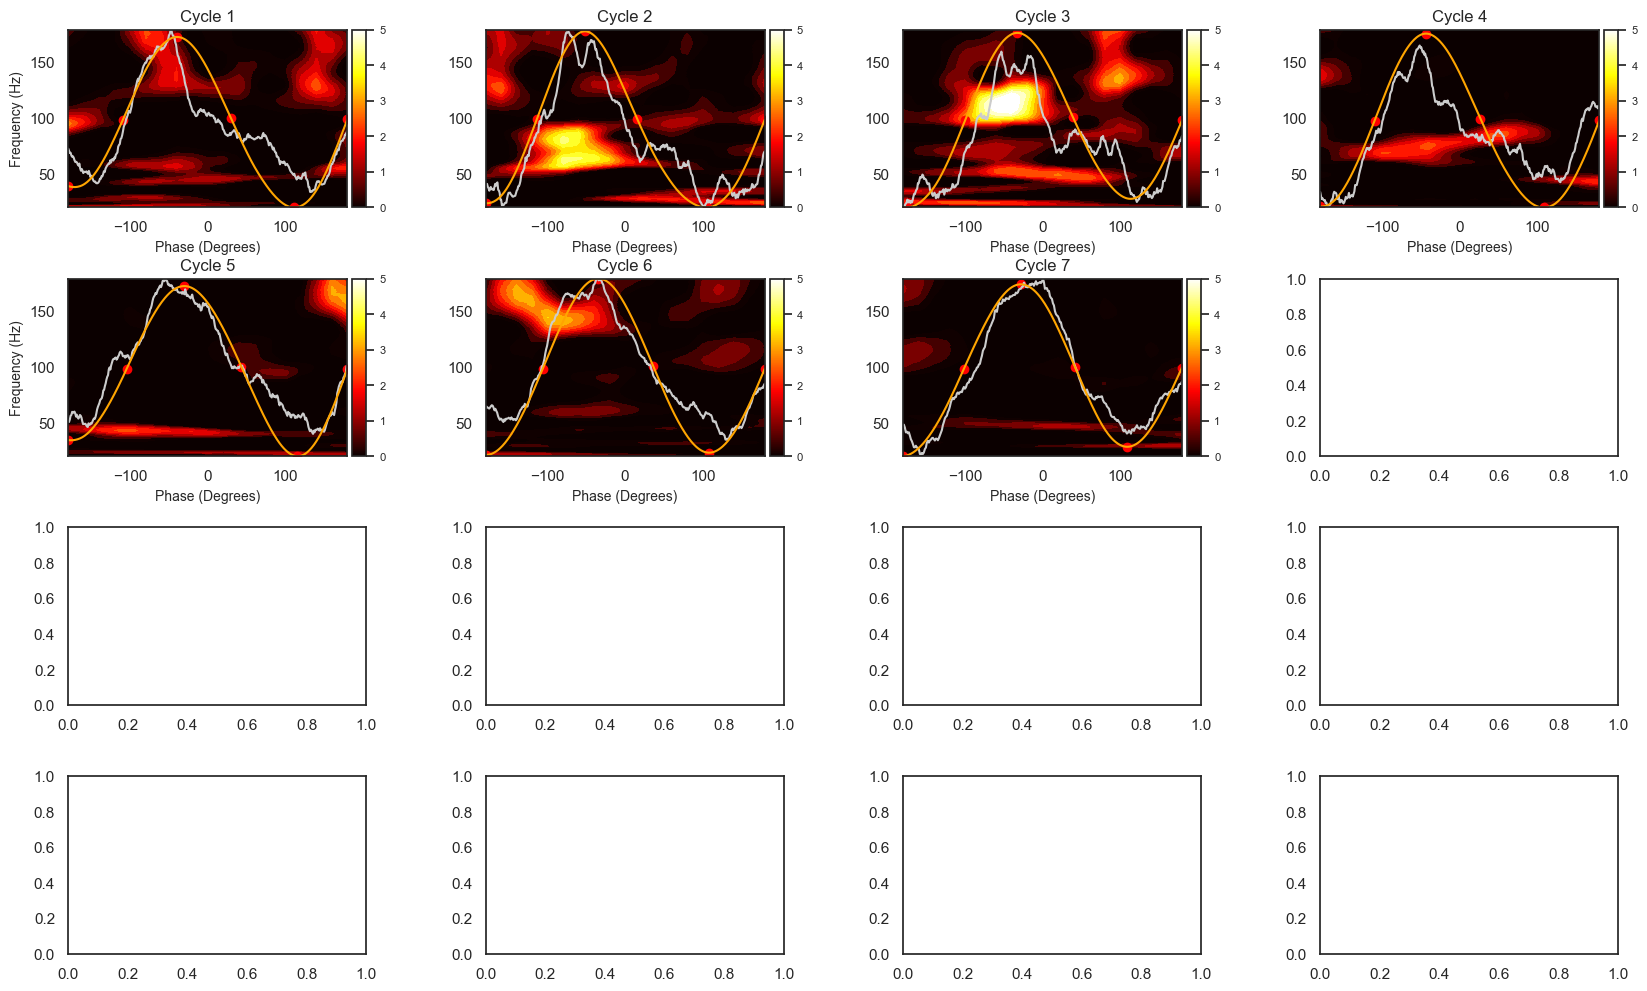

In [24]:
frequencies = np.arange(20, 180, 1)
angles = np.linspace(-180, 180, 19)

n_rows, n_cols = 4, 4
max_plots = n_rows * n_cols

vmin = 0
vmax = 5

n_levels = 20
levels = np.linspace(np.min(FPP), np.max(FPP), n_levels)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for ii in range(min(len(FPP), max_plots)):
    ax = axes[ii // n_cols, ii % n_cols]

    # Create contourf plot with specified levels and normalization
    im = ax.contourf(angles, frequencies, FPP[ii], levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    ax.set_xlabel(r'Phase (Degrees)', fontsize=10)
    if ii % n_cols == 0:
        ax.set_ylabel(r'Frequency (Hz)', fontsize=10)

    ax.set_title(f"Cycle {ii+1}", fontsize=12)
    
    xinds = np.arange(len(all_cycles_inds[ii]))
    raw_lfp = firstRemLFP[all_cycles_inds[ii]]
    theta_part = imf[all_cycles_inds[ii], 5]

    phase_scaled_xinds = np.linspace(angles.min(), angles.max(), len(xinds))
    lfp_scaled_y = (raw_lfp / np.max(np.abs(raw_lfp))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    theta_scaled_y = (theta_part / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()

    # Plot raw LFP and IMF-6 on the current axis
    ax.plot(phase_scaled_xinds, lfp_scaled_y, color=[0.8, 0.8, 0.8], label='Raw LFP')
    ax.plot(phase_scaled_xinds, theta_scaled_y, color='orange', label='IMF-6')

    # Plot control points
    ctrl_points_x = np.interp(all_cycles_ctrl[ii], np.arange(len(xinds)), phase_scaled_xinds)
    ctrl_points_y = (theta_part[all_cycles_ctrl[ii]] / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    ax.scatter(ctrl_points_x, ctrl_points_y, color='red', marker='o', label='Control Points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax, ticks=range(vmin, vmax+5, 5))
    im.set_clim(vmin, vmax)
    cbar.set_ticks(np.linspace(vmin, vmax, 6))
    cbar.ax.tick_params(labelsize=8)
plt.show()


In [25]:
# 1) Top-level containers (they're lists)
print("all_tonic_cycle_ctrls_hpc: len =", len(all_tonic_cycles_ctrls_hpc))
print("all_tonic_cycles_se_hpc : len =", len(all_tonic_cycles_se_hpc))
print("-----------------")
print("number of cycles in this interval: ", len(all_tonic_cycles_ctrls_hpc[0]))
print(all_tonic_cycles_ctrls_hpc[1])


all_tonic_cycle_ctrls_hpc: len = 4
all_tonic_cycles_se_hpc : len = 4
-----------------
number of cycles in this interval:  145
[array([  0,  76, 148, 219, 292, 367]), array([  0,  74, 146, 242, 338, 414]), array([  0,  78, 149, 235, 338, 408]), array([  0,  78, 155, 242, 339, 423]), array([  0,  89, 175, 285, 387, 461]), array([  0,  78, 147, 235,   4, 429]), array([  0,  92, 175, 276,   5, 428]), array([  0,  70, 142, 226, 332, 423]), array([  0,  95, 177, 265, 362, 443]), array([  0,  86, 165, 260,   5, 466]), array([  0, 102, 204, 295, 387, 468]), array([  0,  83, 161, 252,   2, 415]), array([  0,  76, 146, 237,   4, 424]), array([  0,  87, 170, 266, 352, 431]), array([  0,  82, 181, 280, 369, 461]), array([  0,  90, 182, 268, 355, 439]), array([  0,  84, 174, 271, 359, 450]), array([  0,  90, 196, 290, 387, 475]), array([  0,  89, 183, 290, 379, 472]), array([  0,  97, 182, 290, 433, 498]), array([  0,  76, 143, 227, 343, 422]), array([  0,  90, 173, 289, 389, 470]), array([  0,  8

In [ ]:
for i in range(len(all_tonic_cycles_se_hpc)):
    print(f"Interval {i+1}:")
    myInterval = all_tonic_cycles_se_hpc[i]
    for j in range(len(myInterval)):
        cyc_strt = myInterval[j][0]
        cyc_end = myInterval[j][-1]
        print(f"Cycle Start: {cyc_strt}, Cycle End: {cyc_end}")
    print("----------------------------------------")
    
print(len(myInterval))


In [ ]:
control_points = all_tonic_cycles_ctrls_hpc[1]  
for i, cycle_ctrl in enumerate(control_points):
    print(f"Cycle {i}: Control points = {cycle_ctrl}")
    print(f"  Control points (indices): {cycle_ctrl}")

# PPC Calculation

In [28]:
# 1. Extracting tonic & phasic intervals from both HPC & PFC signals
fs = 2500
freq_range = np.arange(20, 182, 2) 
ph_intrvls_hpc = []
ph_intrvls_pfc = []
ton_intrvls_hpc = []
ton_intrvls_pfc = []
for i in range(len(all_tonic_cycles_se_hpc)):
    start_idx = int(tonic_interval_hpc[i, 0] * fs)
    end_idx   = int(tonic_interval_hpc[i, 1] * fs)
    ton_intrvls_hpc.append(lfpHPC[start_idx:end_idx])
    ton_intrvls_pfc.append(lfpPFC[start_idx:end_idx])
for i in range(len(all_phasic_cycles_se_hpc)):
    start_idx = int(phasic_interval_hpc[i, 0] * fs)
    end_idx   = int(phasic_interval_hpc[i, 1] * fs)
    ph_intrvls_hpc.append(lfpHPC[start_idx:end_idx])
    ph_intrvls_pfc.append(lfpPFC[start_idx:end_idx])

In [29]:
# 2. Wavelet Cross Spectrum (WCS) Calculation
ton_all_wcs = []
ph_all_wcs = []
for i in range (len(ton_intrvls_hpc)):
    cwt_lfp1, freqs_lfp1 = pywt.cwt(ton_intrvls_pfc[i], freq_range, 'cmor', sampling_period=1/fs)
    cwt_lfp2, freqs_lfp2 = pywt.cwt(ton_intrvls_hpc[i], freq_range, 'cmor', sampling_period=1/fs)
    cwt_lfp2_conj = np.conj(cwt_lfp2)
    wcs = cwt_lfp1 * cwt_lfp2_conj
    WCS_z = zscore(wcs, axis=1)
    ton_all_wcs.append(WCS_z)
    
for i in range (len(ph_intrvls_hpc)):
    cwt_lfp1, freqs_lfp1 = pywt.cwt(ph_intrvls_pfc[i], freq_range, 'cmor', sampling_period=1/fs)
    cwt_lfp2, freqs_lfp2 = pywt.cwt(ph_intrvls_hpc[i], freq_range, 'cmor', sampling_period=1/fs)
    cwt_lfp2_conj = np.conj(cwt_lfp2)
    wcs = cwt_lfp1 * cwt_lfp2_conj
    WCS_z = zscore(wcs, axis=1)
    ph_all_wcs.append(WCS_z)

c:\Users\Asusiran\AppData\Local\Programs\Python\Python313\Lib\site-packages\pywt\_cwt.py:113: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)
c:\Users\Asusiran\AppData\Local\Programs\Python\Python313\Lib\site-packages\pywt\_cwt.py:113: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)
c:\Users\Asusiran\AppData\Local\Programs\Python\Python313\Lib\site-packages\pywt\_cwt.py:113: FutureWarning: Wavel

In [30]:

# print(ton_all_wcs[0].shape)
# print(len(ton_all_wcs))
# print(np.linspace(-180, 180, 19))

In [31]:
# 3. Storing Theta cycles

ton_th_cyc_strt_end = []
ph_th_cyc_strt_end = []

for i in range(len(all_tonic_cycles_se_hpc)):
    row = []
    for j in range(len(all_tonic_cycles_se_hpc[i])):
        strt = all_tonic_cycles_se_hpc[i][j][0]
        end = all_tonic_cycles_se_hpc[i][j][-1]
        row.append([strt, end])
    ton_th_cyc_strt_end.append(row)

for i in range(len(all_phasic_cycles_se_hpc)):
    row = []
    for j in range(len(all_phasic_cycles_se_hpc[i])):
        strt = all_phasic_cycles_se_hpc[i][j][0]
        end = all_phasic_cycles_se_hpc[i][j][-1]
        row.append([strt, end])
    ph_th_cyc_strt_end.append(row)
    
    
print(np.array(ph_th_cyc_strt_end[0]))
        

[[ 293  645]
 [ 576  952]
 [ 869 1240]
 [1170 1529]
 [1454 1812]
 [1748 2061]
 [2000 2279]]


In [ ]:
# 4. tf -> fph
ton_fpp_all = []
ph_fpp_all = []
for i in range(len(ton_th_cyc_strt_end)):
    cyc_array = np.array(ton_th_cyc_strt_end[i])
    ton_fpp_all.append(bin_tf_to_fpp(cyc_array, ton_all_wcs[i], 20))
for i in range(len(ph_th_cyc_strt_end)):
    cyc_array = np.array(ph_th_cyc_strt_end[i])
    ph_fpp_all.append(bin_tf_to_fpp(cyc_array, ph_all_wcs[i], 20))

In [37]:
print(ton_fpp_all[2].shape)

(175, 81, 20)


In [34]:
# 5. PPC formula
all_PPC_ton = []
all_PPC_ph = []
for fpp in ton_fpp_all:
    W = np.angle(fpp)  # Phase angles
    N, F, B = W.shape
    PPC = np.zeros((F, B), dtype=float)
    # Compute pairwise phase consistency
    for i in range(N):
        for j in range(N):
            PPC += np.cos(W[i] - W[j])  # Real part of the product of complex exponentials
    # Apply normalization term
    PPC = (PPC - N) / (N * (N - 1))
    all_PPC_ton.append(PPC)
    
for fpp in ph_fpp_all:
    W = np.angle(fpp)  # Phase angles
    N, F, B = W.shape
    PPC = np.zeros((F, B), dtype=float)
    # Compute pairwise phase consistency
    for i in range(N):
        for j in range(N):
            PPC += np.cos(W[i] - W[j])  # Real part of the product of complex exponentials
    # Apply normalization term
    PPC = (PPC - N) / (N * (N - 1))
    all_PPC_ph.append(PPC)

In [ ]:
# print(all_PPC_ph[2].shape)

(81, 20)


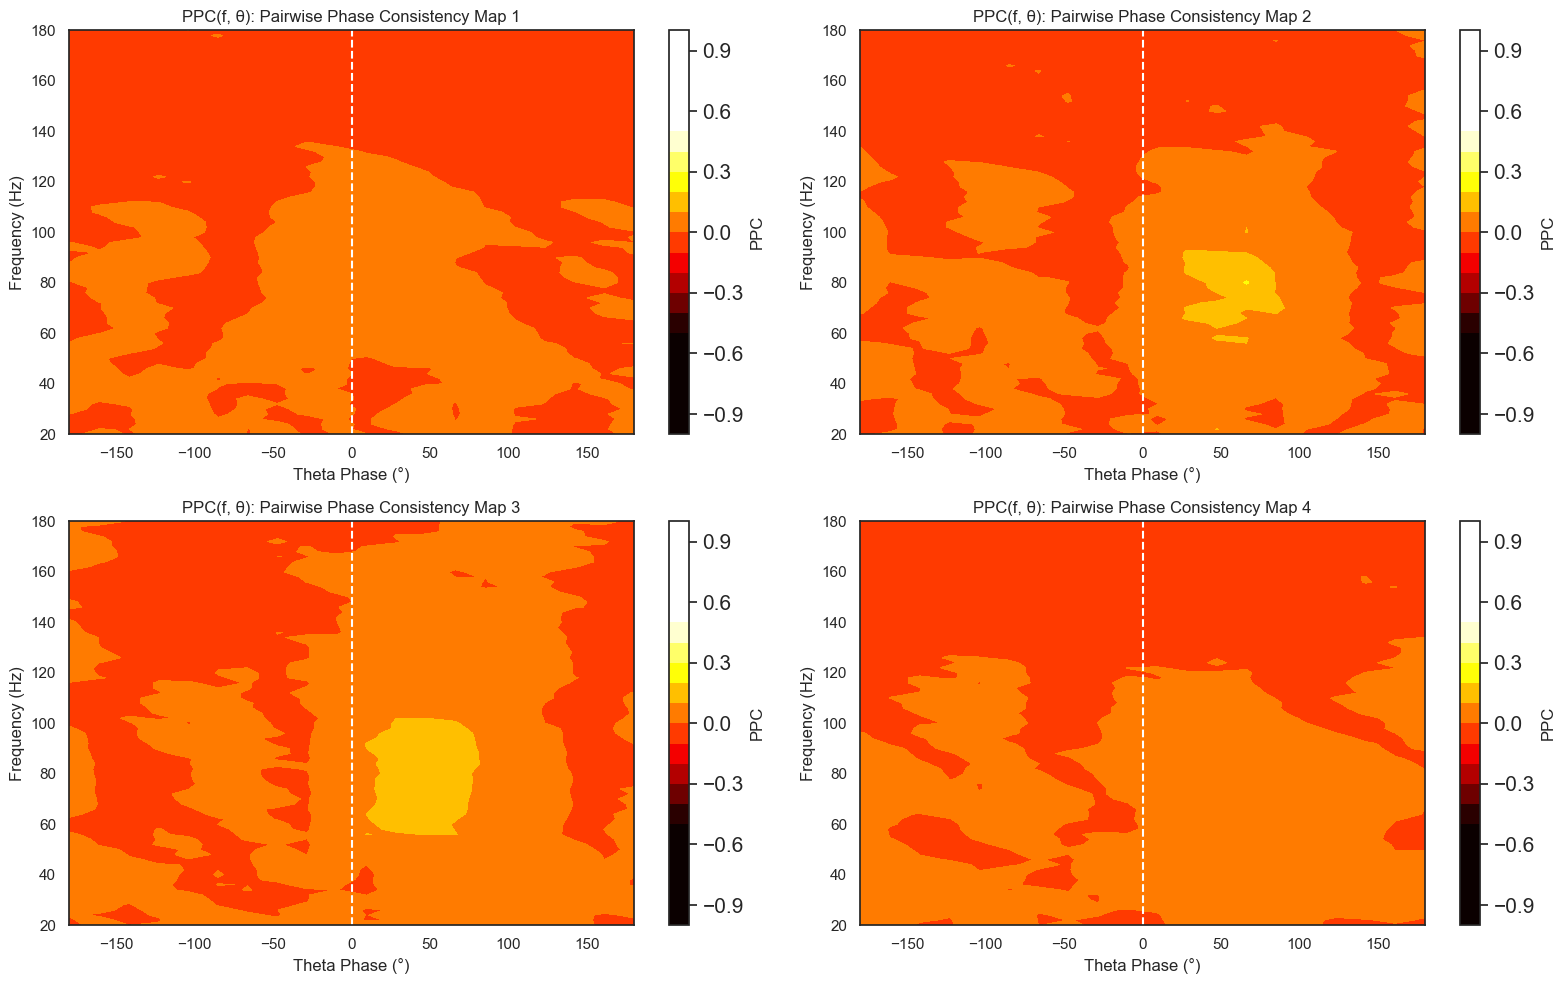

In [ ]:
# 6. Visualize
freq_range = np.arange(20, 182, 2) 
angles = np.linspace(-180, 180, 20)   
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  

# Flatten axes array to index it correctly
axes = axes.flatten()

for i, PPC in enumerate(all_PPC_ton):
    ax = axes[i]
    
    pcm = ax.contourf(
        angles, freq_range, PPC,
        levels=np.linspace(-1, 1, 21), cmap='hot', vmin=-0.5, vmax=0.5
    )

    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label('PPC')
    cbar.ax.tick_params(labelsize=15)

    ax.set_xlabel('Theta Phase (°)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'PPC(f, θ): Pairwise Phase Consistency Map {i+1}')

    ax.axvline(0, color='white', linestyle='--', alpha=1)

plt.tight_layout()
plt.show()
